In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
file_path = 'gdrive/My Drive/DL Project/data_in_csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as stl
stl.use('seaborn')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

import os

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  
  #Loss Plotter
  fig, axs = plt.subplots(2)
  fig.suptitle(title)
  axs[0].plot(epochs, loss, 'b', label='Training loss')
  axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
  axs[0].set_title('Loss')
  axs[0].legend()

  trainAcc = history.history['acc']
  valAcc = history.history['val_acc']

  axs[1].plot(epochs, trainAcc, 'b', label='Training Accuracy')
  axs[1].plot(epochs, valAcc, 'r', label='Validation Accuracy')
  axs[1].set_title('Accuracy')
  axs[1].legend()

  fig.show()

  fig.savefig(title+'.png', bbox_inches='tight')

YIPPY KAY YAY!
Entering AITC.100uM Directory 


(15225, 120, 1)
(TensorShape([Dimension(None), Dimension(120), Dimension(1)]), TensorShape([Dimension(None)]))
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 120, 32)           128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 9605      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 9,739
Trainable params: 9,739
Non-trainable params: 0
_________________________

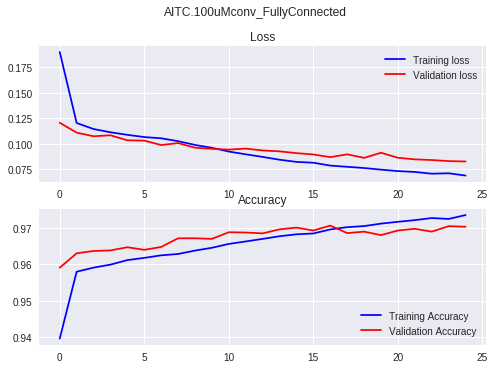

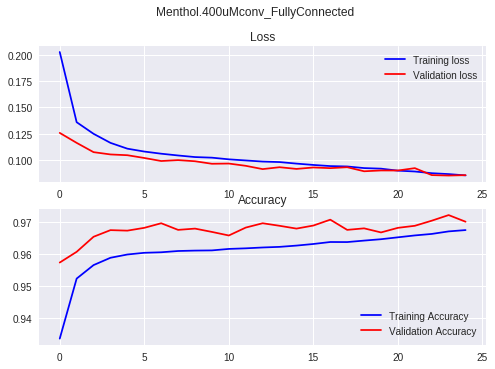

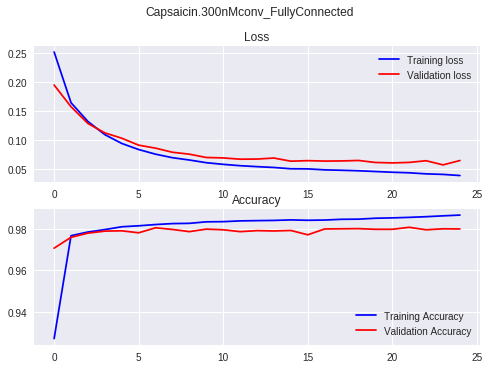

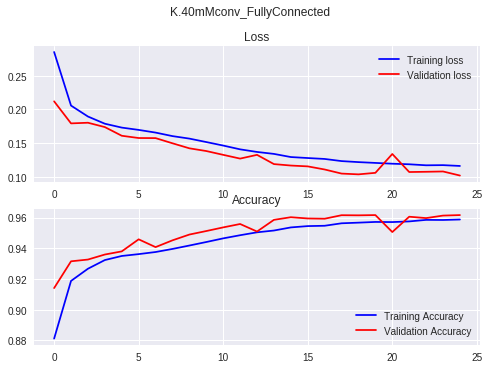

In [12]:
# # #This is where we are peakDeepDetect
superDir = os.getcwd()

#This is where we will be doing our work.
os.chdir('/content/gdrive/My Drive/DL Project/data_in_csv')#'/content/gdrive')
main_dir  = os.getcwd() #make it my main dir
#Find only Directories
expDirs  = next(os.walk('.'))[1]

#Loop Through Each Application!
for i in range(len(expDirs)):
  print("YIPPY KAY YAY!")
  print("Entering " + expDirs[i] +" Directory \n\n")
  os.chdir(expDirs[i])

    ######################################################################
  # First import the Traces
  traces = pd.read_csv("traces.csv", index_col=0)
  # some examples have na values get rid of
  traces = traces.dropna()
  tracesIndex = traces.index
    #Randomize!!
  tracesIndex = tracesIndex[np.random.permutation(len(tracesIndex))]
  traces = traces.loc[tracesIndex,]
  #This need to be a 3 dimensional numpy array
  traces = np.asarray(traces)
  #Add the new Dimension
  traces = traces[...,np.newaxis]

  #Load the Labels
  labels = pd.read_csv("labels.csv", index_col=0)
  #Load lables that match the traces above
  labels = labels.loc[tracesIndex,]
  #Convert to Category
  labels = labels.iloc[:,0].astype('category')
  #convert to np array
  labels = np.asarray(labels)

    #Create Train and Validation Set
  val = int(np.ceil(traces.shape[0]*.33))
  trainSize = traces.shape[0] - val 

  x_train  = traces[:trainSize,...]
  y_train = labels[:trainSize]

  x_test = traces[trainSize:,...]
  y_test = labels[trainSize:]

    # Now DO what we need for the import to LSTM
  BATCH_SIZE = 256
  BUFFER_SIZE = 10000
  train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  test = test.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    #This Doesn't work for 3 dimension datasets
    #X_train, X_test, y_train, y_test = train_test_split(traces, labels, test_size=0.33)

    #Using this as a guide
    #https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

    #This Helps to guide the model and loss
    #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

    # Function to transform data set into 10 peices of 
    # Mean
    # Standard Deviation

    #To feed into LSTM we need 3 Dimensions
    # 1 # of samples (11063)
    # 2 # of features (2 mean and Standar Deviation)
    # 3 # of timesteps
  print(traces.shape)
  model = Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape = traces.shape[-2:]),
      tf.keras.layers.MaxPooling1D(pool_size=2),
      tf.keras.layers.Flatten(),
      Dense(5, activation='relu'),
      Dense(1, activation='sigmoid'),

  ])

  model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['acc'])
  
  print(train.output_shapes)
  model.summary()

  EVALUATION_INTERVAL = 500
  EPOCHS = 25

  history = model.fit(train, epochs = EPOCHS, 
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data = test,
                      validation_steps=50)

    # history = model.fit(x_train, y_train, epochs=25, 
    #                     validation_data=(x_test,y_test ))

  print("This is the loss vs Accuracy for" + expDirs[i])
  plot_train_history(history, expDirs[i]+"conv_FullyConnected")     
    
    #Save the ModelYYYYYYYYYYY
  model.save(expDirs[i]+'exp1.h5')

    ##########################################################
    #Now that we have a model that works fairly well 
    #lets do some data analysis

    #These are Predicted Values
  labsPred = model.predict_classes(traces)
  labsPred = pd.DataFrame(labsPred) #convert to df

  #convert real to DataFrame
  labs = pd.DataFrame(labels)

  realTest = pd.concat([labs, labsPred], axis=1)

  realTest.columns = ['Real', "Predicted"]

  realTest = realTest.set_index(tracesIndex)

  realTest.to_csv('conv_FullyConected.csv')

    #These are Predicted Values
  realVsPredCT = pd.crosstab(np.asarray(labsPred).flatten(), np.asarray(labs).flatten(), rownames=['pred'], colnames=['real'])
  
  print(realVsPredCT)

  del model

  os.chdir(main_dir)
